In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.hidden_size = hidden_size
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        self.learning_rate = learning_rate

    def forward(self, inputs):
        h_prev = np.zeros((self.hidden_size, 1))
        self.cache = {'h': [], 'inputs': inputs}
        
        for x in inputs:
            x = x.reshape(-1, 1)
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + self.bh)
            self.cache['h'].append(h)
            h_prev = h
        
        self.cache['h'] = np.array(self.cache['h'])
        output = np.dot(self.Why, h) + self.by
        return output, h

    def backward(self, d_output, h_last):
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dh_next = np.zeros_like(h_last)

        for t in reversed(range(len(self.cache['inputs']))):
            dh = np.dot(self.Why.T, d_output) + dh_next
            dh_raw = (1 - self.cache['h'][t] ** 2) * dh
            dbh += dh_raw
            dWxh += np.dot(dh_raw, self.cache['inputs'][t].reshape(1, -1))
            dWhh += np.dot(dh_raw, self.cache['h'][t - 1].T) if t > 0 else 0
            dh_next = np.dot(self.Whh.T, dh_raw)

        dWhy += np.dot(d_output, self.cache['h'][-1].T)
        dby += d_output

        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -1, 1, out=dparam)

        return dWxh, dWhh, dWhy, dbh, dby

    def update_weights(self, dWxh, dWhh, dWhy, dbh, dby):
        self.Wxh -= self.learning_rate * dWxh
        self.Whh -= self.learning_rate * dWhh
        self.Why -= self.learning_rate * dWhy
        self.bh -= self.learning_rate * dbh
        self.by -= self.learning_rate * dby

    def train(self, X_train, y_train, epochs=100, window_size=10):
        epoch_losses = []
        for epoch in range(epochs):
            loss = 0
            for X, y in zip(X_train, y_train):
                
                X_windows = [X[i:i+window_size] for i in range(len(X) - window_size + 1)]
                
                X_window = X_windows[-1]
                
                output, h_last = self.forward(X_window)
                
                loss += np.sum((output - y.reshape(-1, 1)) ** 2)
                
                d_output = 2 * (output - y.reshape(-1, 1))
                dWxh, dWhh, dWhy, dbh, dby = self.backward(d_output, h_last)
                
                self.update_weights(dWxh, dWhh, dWhy, dbh, dby)
            
            epoch_losses.append(loss / len(X_train))
            print(f"Epoch {epoch + 1}, Loss: {loss / len(X_train)}")
        
        plt.plot(range(epochs), epoch_losses)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Epochs vs Loss')
        plt.show()

    def predict(self, X):
        output, _ = self.forward(X)
        return output

In [3]:
def generate_synthetic_data_univariate(seq_length=100, freq=0.1, noise_level=0.1):
    t = np.linspace(0, seq_length * freq, seq_length)
    data = np.sin(t) + noise_level * np.random.randn(seq_length)
    return data

def generate_synthetic_data_multivariate(seq_length=100, freq=0.1, noise_level=0.1):
    t = np.linspace(0, seq_length * freq, seq_length)
    data1 = np.sin(t) + noise_level * np.random.randn(seq_length)
    data2 = np.cos(t) + noise_level * np.random.randn(seq_length)
    return np.column_stack([data1, data2])

Epoch 1, Loss: 0.4553772159373368
Epoch 2, Loss: 0.12652538470958105
Epoch 3, Loss: 0.05991349829541841
Epoch 4, Loss: 0.05623064143533321
Epoch 5, Loss: 0.05375760891522525
Epoch 6, Loss: 0.0520860485946862
Epoch 7, Loss: 0.051011961913514973
Epoch 8, Loss: 0.05039225440926401
Epoch 9, Loss: 0.05016877119636593
Epoch 10, Loss: 0.05029245507174325
Epoch 11, Loss: 0.05075434386626775
Epoch 12, Loss: 0.051570237496897965
Epoch 13, Loss: 0.05270742682658365
Epoch 14, Loss: 0.05406826724511965
Epoch 15, Loss: 0.0555050961070169
Epoch 16, Loss: 0.05687058615282334
Epoch 17, Loss: 0.05803421594343375
Epoch 18, Loss: 0.05889917402624342
Epoch 19, Loss: 0.05943996840599781
Epoch 20, Loss: 0.05968073704074686
Epoch 21, Loss: 0.05966944528728286
Epoch 22, Loss: 0.05946006358534396
Epoch 23, Loss: 0.059091248725407206
Epoch 24, Loss: 0.058584980937384665
Epoch 25, Loss: 0.05796128981681611
Epoch 26, Loss: 0.0572714579302212
Epoch 27, Loss: 0.05654895238280332
Epoch 28, Loss: 0.05581723503529536
E

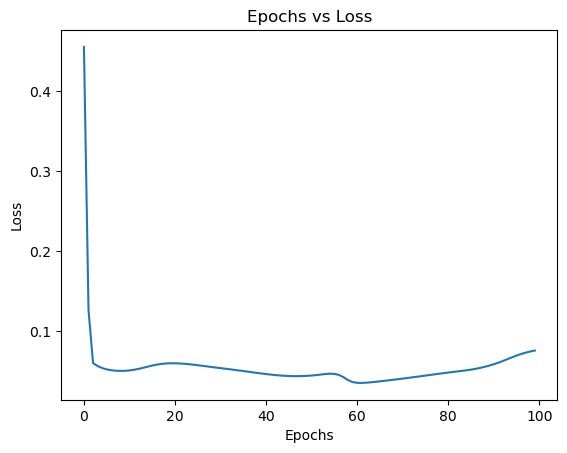

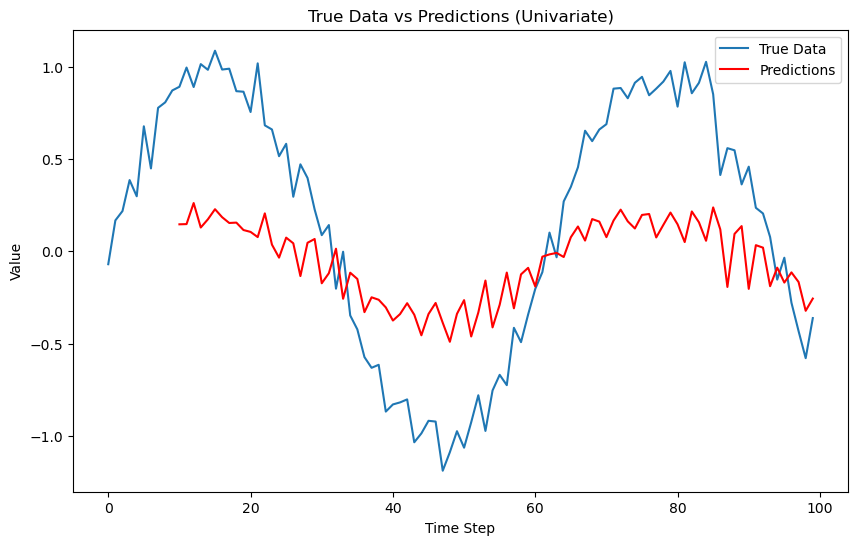

In [4]:
seq_length = 100
data_univariate = generate_synthetic_data_univariate(seq_length)

window_size = 10
X_train_univariate = [data_univariate[i:i+window_size] for i in range(len(data_univariate) - window_size)]
y_train_univariate = [data_univariate[i + window_size] for i in range(len(data_univariate) - window_size)]

rnn_univariate = SimpleRNN(input_size=1, hidden_size=20, output_size=1, learning_rate=0.01)
rnn_univariate.train(X_train_univariate, y_train_univariate, epochs=100, window_size=window_size)

predictions_univariate = [rnn_univariate.predict(X_window) for X_window in X_train_univariate]

predictions_univariate = np.array(predictions_univariate).reshape(-1)
plt.figure(figsize=(10, 6))
plt.plot(range(seq_length), data_univariate, label="True Data")
plt.plot(range(window_size, seq_length), predictions_univariate, label="Predictions", color='red')
plt.legend()
plt.title('True Data vs Predictions (Univariate)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

Epoch 1, Loss: 0.9058611074769692
Epoch 2, Loss: 0.24227584963781293
Epoch 3, Loss: 0.058926826816663655
Epoch 4, Loss: 0.052264358351820535
Epoch 5, Loss: 0.04365931979465645
Epoch 6, Loss: 0.042050033269824566
Epoch 7, Loss: 0.041298722930816364
Epoch 8, Loss: 0.04055722756847343
Epoch 9, Loss: 0.04019193217467971
Epoch 10, Loss: 0.03998889541795194
Epoch 11, Loss: 0.039480671779601254
Epoch 12, Loss: 0.03891494298827881
Epoch 13, Loss: 0.03858102606498863
Epoch 14, Loss: 0.0384364937315236
Epoch 15, Loss: 0.03837003559581517
Epoch 16, Loss: 0.03833281445047827
Epoch 17, Loss: 0.038216126062447786
Epoch 18, Loss: 0.037996583832952555
Epoch 19, Loss: 0.03776915723328809
Epoch 20, Loss: 0.037595051234882645
Epoch 21, Loss: 0.0374669741068415
Epoch 22, Loss: 0.0373642606753209
Epoch 23, Loss: 0.03727028984798331
Epoch 24, Loss: 0.03717805798790418
Epoch 25, Loss: 0.03708293116934742
Epoch 26, Loss: 0.036976575364214406
Epoch 27, Loss: 0.0368414630954771
Epoch 28, Loss: 0.036671059594017

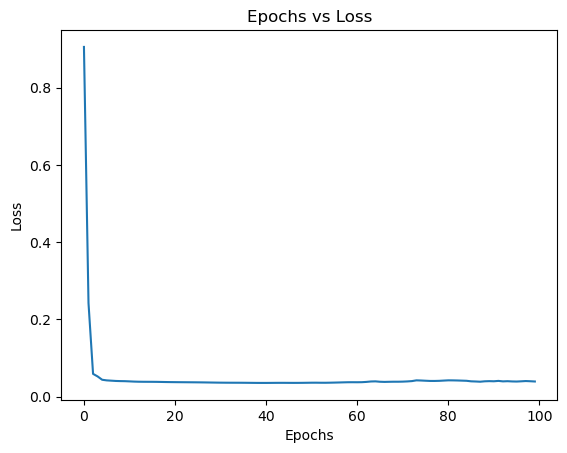

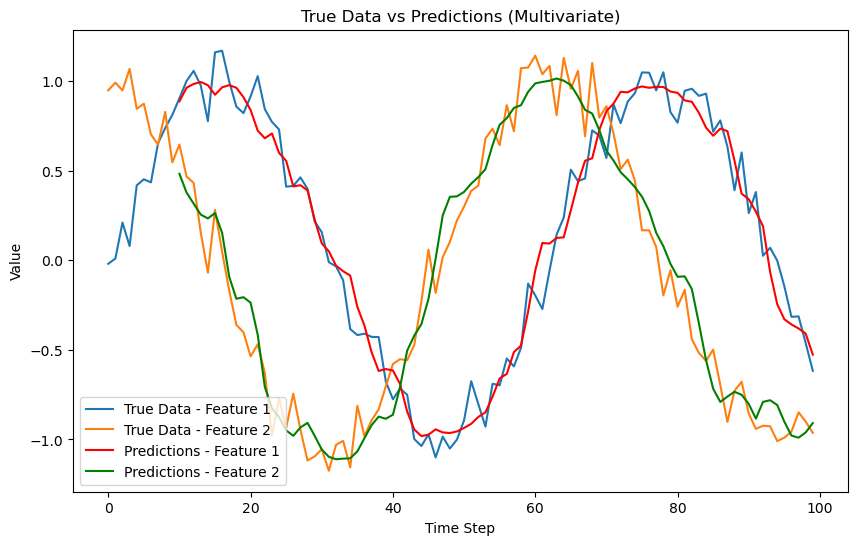

In [5]:
data_multivariate = generate_synthetic_data_multivariate(seq_length)

X_train_multivariate = [data_multivariate[i:i+window_size] for i in range(len(data_multivariate) - window_size)]
y_train_multivariate = [data_multivariate[i + window_size] for i in range(len(data_multivariate) - window_size)]

rnn_multivariate = SimpleRNN(input_size=2, hidden_size=20, output_size=2, learning_rate=0.01)
rnn_multivariate.train(X_train_multivariate, y_train_multivariate, epochs=100, window_size=window_size)

predictions_multivariate = [rnn_multivariate.predict(X_window) for X_window in X_train_multivariate]

predictions_multivariate = np.array(predictions_multivariate).reshape(-1, 2)
plt.figure(figsize=(10, 6))
plt.plot(range(seq_length), data_multivariate[:, 0], label="True Data - Feature 1")
plt.plot(range(seq_length), data_multivariate[:, 1], label="True Data - Feature 2")
plt.plot(range(window_size, seq_length), predictions_multivariate[:, 0], label="Predictions - Feature 1", color='red')
plt.plot(range(window_size, seq_length), predictions_multivariate[:, 1], label="Predictions - Feature 2", color='green')
plt.legend()
plt.title('True Data vs Predictions (Multivariate)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

In [6]:
df_tesla = pd.read_excel("Tesla_Stock.xlsx")

df_tesla = df_tesla.drop(columns=["Unnamed: 0"], errors="ignore")

df_tesla["Date"] = pd.to_datetime(df_tesla["Date"])

df_tesla.set_index("Date", inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_tesla)

df_scaled = pd.DataFrame(scaled_data, columns=df_tesla.columns, index=df_tesla.index)

df_scaled.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,0.013359,0.011263,0.012148,0.012594,0.067348
2015-01-05,0.011979,0.010149,0.011122,0.011059,0.077377
2015-01-06,0.011234,0.009770,0.010626,0.011257,0.092210
2015-01-07,0.011780,0.009866,0.011563,0.011202,0.037529
2015-01-08,0.011690,0.009704,0.011602,0.011147,0.045400


Epoch 1, Loss: 0.008665520604574345
Epoch 2, Loss: 0.012050058871383237
Epoch 3, Loss: 0.008703166520938319
Epoch 4, Loss: 0.006513875260734691
Epoch 5, Loss: 0.005635736670548603
Epoch 6, Loss: 0.005460110013424245
Epoch 7, Loss: 0.005476234511686434
Epoch 8, Loss: 0.005541813099445945
Epoch 9, Loss: 0.005543619923919652
Epoch 10, Loss: 0.005517915846589256
Epoch 11, Loss: 0.00544331365540566
Epoch 12, Loss: 0.005363087344782337
Epoch 13, Loss: 0.005277167238125131
Epoch 14, Loss: 0.005206344300823699
Epoch 15, Loss: 0.005149037747808958
Epoch 16, Loss: 0.0051096776214267555
Epoch 17, Loss: 0.005083960291882961
Epoch 18, Loss: 0.0050709869134793915
Epoch 19, Loss: 0.005066031188933914
Epoch 20, Loss: 0.005068117198997152
Epoch 21, Loss: 0.005074695015318542
Epoch 22, Loss: 0.005085242100778554
Epoch 23, Loss: 0.005099297633723153
Epoch 24, Loss: 0.005117355720381105
Epoch 25, Loss: 0.005139323709695317
Epoch 26, Loss: 0.00516508486693903
Epoch 27, Loss: 0.00519546593779798
Epoch 28, L

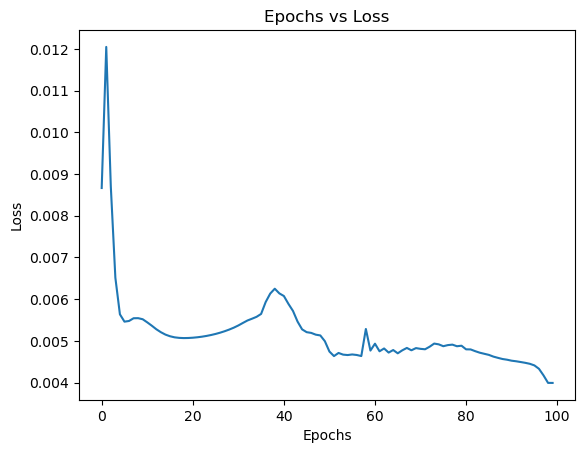

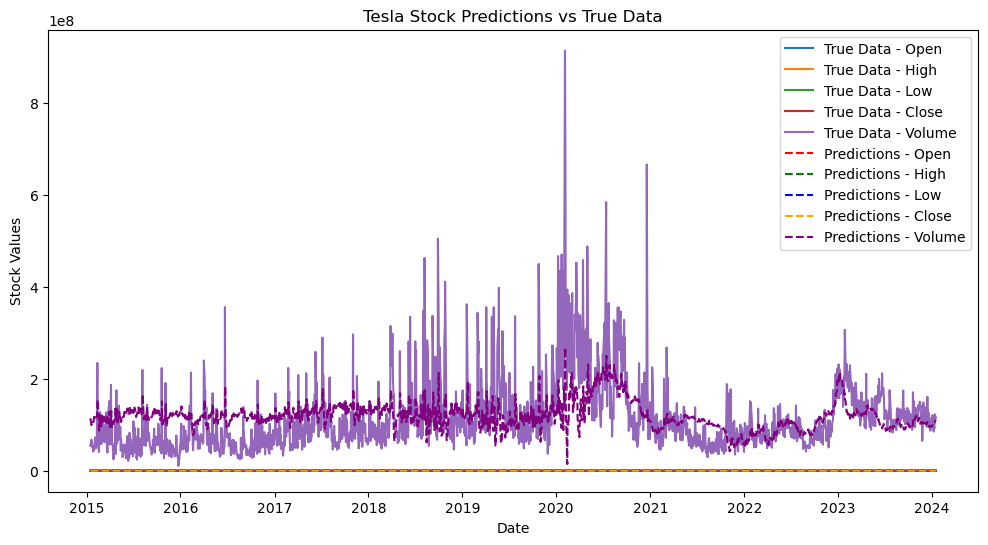

In [7]:
window_size = 10

X_train_multivariate = [df_scaled.values[i:i+window_size] for i in range(len(df_scaled) - window_size)]
y_train_multivariate = [df_scaled.values[i + window_size] for i in range(len(df_scaled) - window_size)]

X_train_multivariate = np.array(X_train_multivariate)
y_train_multivariate = np.array(y_train_multivariate)

rnn_multivariate = SimpleRNN(input_size=5, hidden_size=20, output_size=5, learning_rate=0.01)

rnn_multivariate.train(X_train_multivariate, y_train_multivariate, epochs=100, window_size=window_size)

predictions_multivariate = [rnn_multivariate.predict(X_window) for X_window in X_train_multivariate]

predictions_multivariate = np.array(predictions_multivariate).reshape(-1, 5)

predictions_multivariate = scaler.inverse_transform(predictions_multivariate)
y_train_actual = scaler.inverse_transform(y_train_multivariate)

plt.figure(figsize=(12, 6))
plt.plot(df_scaled.index[window_size:], y_train_actual[:, 0], label="True Data - Open")
plt.plot(df_scaled.index[window_size:], y_train_actual[:, 1], label="True Data - High")
plt.plot(df_scaled.index[window_size:], y_train_actual[:, 2], label="True Data - Low")
plt.plot(df_scaled.index[window_size:], y_train_actual[:, 3], label="True Data - Close")
plt.plot(df_scaled.index[window_size:], y_train_actual[:, 4], label="True Data - Volume")

plt.plot(df_scaled.index[window_size:], predictions_multivariate[:, 0], label="Predictions - Open", color='red', linestyle="dashed")
plt.plot(df_scaled.index[window_size:], predictions_multivariate[:, 1], label="Predictions - High", color='green', linestyle="dashed")
plt.plot(df_scaled.index[window_size:], predictions_multivariate[:, 2], label="Predictions - Low", color='blue', linestyle="dashed")
plt.plot(df_scaled.index[window_size:], predictions_multivariate[:, 3], label="Predictions - Close", color='orange', linestyle="dashed")
plt.plot(df_scaled.index[window_size:], predictions_multivariate[:, 4], label="Predictions - Volume", color='purple', linestyle="dashed")

plt.legend()
plt.title('Tesla Stock Predictions vs True Data')
plt.xlabel('Date')
plt.ylabel('Stock Values')
plt.show()